In [35]:
#import packages
import pandas as pd
import numpy as np
import datetime as dt

import yfinance as yf

import statsmodels.api as sm
from statsmodels.stats import diagnostic as smd
from statsmodels.stats.sandwich_covariance import cov_hac

import matplotlib.pyplot as plt

pd.set_option("display.float_format", "{:,.2f}".format)

In [36]:
TICKERS = ["ADBE","ALB","GOOGL","BRK-B","QTUM","ONOF","RSP","MSFT","PLTR",
           "PYPL","RNMBY","XLE","TMUS","VOO","VXUS","VZ"] #select needed tickers

In [37]:
#download data from yahoo finance, px is our tickers, from start to end, with monthly prices, 
#no progress bar showing up (progress false), and auto_adjust which makes adj prices to close prics

px = yf.download(TICKERS, period="5y", interval="1mo", auto_adjust=True) 

#The if isinstance(px.columns, pd.MultiIndex): line checks whether the columns are multi-level
#If they are, it picks only the "Close" prices (or "Adj Close" if "Close" doesn’t exist).
#So you end up with a simple DataFrame where each column is one ticker 
if isinstance(px.columns, pd.MultiIndex):
    px = px["Close"] if "Close" in px.columns else px["Adj Close"]
else:
    px = px

#removes rows that are completely empty (in case some months have missing data for all tickers)
#.dropna(axis=1, how="any") → removes any columns (tickers) that have even a single missing value -> This step gives you a clean dataset — no NaNs
px = px.dropna(axis = 1, how="all")

px.head() #print first five rows

[*********************100%***********************]  16 of 16 completed


Ticker,ADBE,ALB,BRK-B,GOOGL,MSFT,ONOF,PLTR,PYPL,QTUM,RNMBY,RSP,TMUS,VOO,VXUS,VZ,XLE
Date,,,,,,,,,,,,,,,,
2020-11-01,478.47,128.19,228.91,87.12,205.26,NaN,27.11,214.12,37.47,16.73,113.20,129.07,309.23,49.25,44.77,30.28
2020-12-01,500.12,139.08,231.87,87.03,213.82,NaN,23.55,234.20,39.72,20.00,117.49,130.92,319.51,51.62,43.54,31.22
2021-01-01,458.77,153.77,227.87,90.74,222.99,NaN,35.18,234.31,42.54,19.48,116.94,122.41,317.54,52.26,40.58,32.83
2021-02-01,459.67,148.62,240.51,100.40,223.40,23.64,23.90,259.85,44.58,18.51,124.06,116.48,326.32,53.47,41.42,40.20
2021-03-01,475.37,138.13,255.47,102.42,227.18,24.53,23.29,242.84,45.03,18.49,130.95,121.64,340.05,54.33,43.56,40.96


In [38]:
#calculate monthly returns
rets = px.pct_change().dropna() #command for calc returns

#print summary
print("\nMonthly returns computed.")
print("Shape:", rets.shape)
print("\nHead:")
print(rets.head(3))
print("\nSummary stats (monthly):")
print(rets.describe().T)


Monthly returns computed.
Shape: (56, 16)

Head:
Ticker      ADBE   ALB  BRK-B  GOOGL  MSFT  ONOF  PLTR  PYPL  QTUM  RNMBY  \
Date                                                                        
2021-03-01  0.03 -0.07   0.06   0.02  0.02  0.04 -0.03 -0.07  0.01  -0.00   
2021-04-01  0.07  0.15   0.08   0.14  0.07  0.05 -0.01  0.08  0.02   0.04   
2021-05-01 -0.01 -0.01   0.05   0.00 -0.01  0.01 -0.00 -0.01 -0.00   0.01   

Ticker      RSP  TMUS  VOO  VXUS    VZ  XLE  
Date                                         
2021-03-01 0.06  0.04 0.04  0.02  0.05 0.02  
2021-04-01 0.05  0.05 0.06  0.03 -0.01 0.02  
2021-05-01 0.02  0.07 0.01  0.03 -0.01 0.06  

Summary stats (monthly):
        count  mean  std   min   25%   50%  75%  max
Ticker                                              
ADBE    56.00  0.00 0.10 -0.26 -0.08 -0.01 0.07 0.25
ALB     56.00  0.00 0.14 -0.25 -0.09 -0.02 0.13 0.35
BRK-B   56.00  0.01 0.06 -0.14 -0.03  0.02 0.06 0.11
GOOGL   56.00  0.02 0.08 -0.18 -0.04  0.03 

In [39]:
#Annualized mean & covariance (pretty output, fixed)

# Compute annualized mean and covariance
mu = (1 + rets.mean()) ** 12 - 1   # pandas Series, annual compounded return
cov = rets.cov()  * 12             # pandas DataFrame, annual covar

# --- Ensure both are pandas objects with proper labels ---
mu_df = pd.DataFrame(mu, columns=["Annualized Mean"])   #create dataframe for annualized mean
mu_df["Annualized Mean (%)"] = mu_df["Annualized Mean"] * 100 #ceate dataframe for annualized mean in %

cov_df = pd.DataFrame(cov, index=rets.columns, columns=rets.columns) #creates df for covar

# --- Pretty display ---
print(" Annualized Statistics\n")

print("---- Annualized Mean Returns ----")
display(mu_df.style.format({
    "Annualized Mean": "{:.4f}",
    "Annualized Mean (%)": "{:.2f}%"
}))

print("\n---- Annualized Covariance Matrix ----")
display(cov_df.style.background_gradient(cmap="RdYlGn", axis=None).format("{:.4f}"))

# --- Add annualized volatility summary ---
ann_vol = np.sqrt(np.diag(cov_df))  #basically square root of the annual variance -> stdev = volatility
vol_df = pd.DataFrame({
    "Annualized Volatility": ann_vol,
    "Volatility (%)": ann_vol * 100
}, index=cov_df.columns)

print("\n---- Annualized Volatility ----")
display(vol_df.style.format({
    "Annualized Volatility": "{:.4f}",
    "Volatility (%)": "{:.2f}%"
}))

corr_df = rets.corr()
print("\n---- Correlation Matrix ----")
display(corr_df.style.background_gradient(cmap="coolwarm", axis=None).format("{:.3f}"))

 Annualized Statistics

---- Annualized Mean Returns ----


,Annualized Mean,Annualized Mean (%)
Ticker,,
ADBE,0.0068,0.68%
ALB,0.0273,2.73%
BRK-B,0.1855,18.55%
GOOGL,0.2656,26.56%
MSFT,0.2292,22.92%
ONOF,0.1146,11.46%
PLTR,0.9227,92.27%
PYPL,-0.1845,-18.45%
QTUM,0.2447,24.47%



---- Annualized Covariance Matrix ----


Ticker,ADBE,ALB,BRK-B,GOOGL,MSFT,ONOF,PLTR,PYPL,QTUM,RNMBY,RSP,TMUS,VOO,VXUS,VZ,XLE
Ticker,,,,,,,,,,,,,,,,
ADBE,0.1303,0.0377,0.0236,0.0430,0.0523,0.0278,0.0751,0.0428,0.0412,-0.0177,0.0316,0.0135,0.0379,0.0274,0.0192,0.0231
ALB,0.0377,0.2453,0.0200,0.0402,0.0146,0.0396,0.0470,0.0695,0.0454,-0.0411,0.0423,0.0201,0.0364,0.0280,-0.0009,0.0464
BRK-B,0.0236,0.0200,0.0364,0.0064,0.0101,0.0119,0.0173,0.0206,0.0125,0.0299,0.0214,0.0187,0.0182,0.0173,0.0149,0.0259
GOOGL,0.0430,0.0402,0.0064,0.0754,0.0376,0.0208,0.0679,0.0400,0.0418,-0.0206,0.0190,-0.0019,0.0267,0.0200,-0.0025,-0.0002
MSFT,0.0523,0.0146,0.0101,0.0376,0.0518,0.0208,0.0604,0.0256,0.0342,0.0005,0.0189,-0.0020,0.0264,0.0179,0.0102,-0.0001
ONOF,0.0278,0.0396,0.0119,0.0208,0.0208,0.0227,0.0269,0.0315,0.0238,-0.0123,0.0194,0.0062,0.0200,0.0144,0.0034,0.0110
PLTR,0.0751,0.0470,0.0173,0.0679,0.0604,0.0269,0.5577,0.0730,0.0843,0.0322,0.0250,0.0052,0.0408,0.0191,-0.0161,-0.0323
PYPL,0.0428,0.0695,0.0206,0.0400,0.0256,0.0315,0.0730,0.1460,0.0377,-0.0364,0.0363,0.0121,0.0344,0.0310,-0.0010,0.0206
QTUM,0.0412,0.0454,0.0125,0.0418,0.0342,0.0238,0.0843,0.0377,0.0545,0.0079,0.0249,0.0044,0.0286,0.0227,0.0051,0.0075



---- Annualized Volatility ----


,Annualized Volatility,Volatility (%)
Ticker,,
ADBE,0.3610,36.10%
ALB,0.4953,49.53%
BRK-B,0.1909,19.09%
GOOGL,0.2747,27.47%
MSFT,0.2277,22.77%
ONOF,0.1508,15.08%
PLTR,0.7468,74.68%
PYPL,0.3821,38.21%
QTUM,0.2335,23.35%



---- Correlation Matrix ----


Ticker,ADBE,ALB,BRK-B,GOOGL,MSFT,ONOF,PLTR,PYPL,QTUM,RNMBY,RSP,TMUS,VOO,VXUS,VZ,XLE
Ticker,,,,,,,,,,,,,,,,
ADBE,1.000,0.211,0.343,0.434,0.637,0.510,0.279,0.310,0.489,-0.097,0.534,0.179,0.664,0.505,0.260,0.246
ALB,0.211,1.000,0.212,0.295,0.130,0.530,0.127,0.367,0.392,-0.163,0.521,0.194,0.465,0.377,-0.009,0.360
BRK-B,0.343,0.212,1.000,0.122,0.232,0.413,0.121,0.283,0.281,0.309,0.684,0.468,0.603,0.602,0.382,0.520
GOOGL,0.434,0.295,0.122,1.000,0.602,0.503,0.331,0.381,0.651,-0.147,0.422,-0.034,0.615,0.484,-0.045,-0.002
MSFT,0.637,0.130,0.232,0.602,1.000,0.606,0.355,0.294,0.643,0.004,0.507,-0.042,0.733,0.522,0.220,-0.002
ONOF,0.510,0.530,0.413,0.503,0.606,1.000,0.239,0.547,0.677,-0.161,0.784,0.197,0.841,0.636,0.111,0.280
PLTR,0.279,0.127,0.121,0.331,0.355,0.239,1.000,0.256,0.484,0.085,0.205,0.033,0.346,0.170,-0.105,-0.166
PYPL,0.310,0.367,0.283,0.381,0.294,0.547,0.256,1.000,0.423,-0.188,0.580,0.152,0.570,0.540,-0.012,0.207
QTUM,0.489,0.392,0.281,0.651,0.643,0.677,0.484,0.423,1.000,0.067,0.652,0.090,0.776,0.647,0.108,0.124


**Covariance** -> measures how two variables move together — in direction and magnitude, but not standardized

- CoVar **<0** Stock A and B tend to move in **opposite** directions

- CoVar **>0** Stock A and B tend to move in the **same** direction

- CoVar **around 0** no relationship


_Example:_
If AAPL and MSFT both go up and down together, their covariance is positive.
If AAPL rises when Gold falls, their covariance is negative.

_Covariance_ is used in the covariance matrix (Σ) to calculate _portfolio variance_

**Correlation**
-> standardized version of covariance — it measures the strength and direction of the relationship, independent of scale.

- Corr: **+1** Perfect **positive** relationship (move exactly together)

- Corr: **-1** Perfect **negative** relationship (move exactly opposite)

- Corr: **0** no linear relationship

**Correlation** is mainly used to understand diversification potential:

- _Negative correlation_ → high diversification benefit.
- _High correlation_ → assets behave similarly, limited diversification.

In [40]:
#Monte Carlo portfolios (long-only, weights >= 0, sum to 1)

#Monte Carlo Simulation is used in stats for simulating different events for different outcomes, very interesting concept :)

N = 3000 #number of portfolio simulations
n_assets = len(rets.columns) #number of investable asssets (= to number of columns in the return table, here 3 etfs)

weights = np.random.dirichlet(np.ones(n_assets), size=N) # Random weights that each sum to 1

mu_vec  = mu_df["Annualized Mean"].values #Pulls  annualized expected returns vector (shape (n_assets,)).
cov_mat = cov_df.values                   #Pulls  annualized covar matrix (shape (n_assets, n_assets)), .values ensures NumPy arrays for fast linear algebra.



#Matrix–vector multiply: (N, n_assets) @ (n_assets,) → (N,)
port_rets = weights @ mu_vec #For each portfolio row w, computes expected return μ_p = wᵀ μ

#Efficiently computes all portfolio variances σ_p² = wᵀ Σ w in one go
#Shapes: weights (N×A), cov_mat (A×A), weights (N×A)
#Multiply weights and cov_mat, then elementwise with weights, and sum over asset axes
#The -> i means “give me the N diagonal results only” (one per portfolio).
port_vars = np.einsum("ij,jk,ik->i", weights, cov_mat, weights)

#square root of port_vars = port_stdev
port_stds = np.sqrt(port_vars)

print("Portfolio simulation")
print("\nWeights row sums (first 5):", np.round(weights[:5].sum(axis=1), 6))
print("\nFirst 5 portfolios (σ, μ):")
for s, r in list(zip(port_stds[:5], port_rets[:5])):
    print(f"  sigma={s:.2%}, mu={r:.2%}")

Portfolio simulation

Weights row sums (first 5): [1. 1. 1. 1. 1.]

First 5 portfolios (σ, μ):
  sigma=16.77%, mu=34.05%
  sigma=17.86%, mu=20.27%
  sigma=16.07%, mu=18.10%
  sigma=16.33%, mu=12.75%
  sigma=17.18%, mu=19.64%


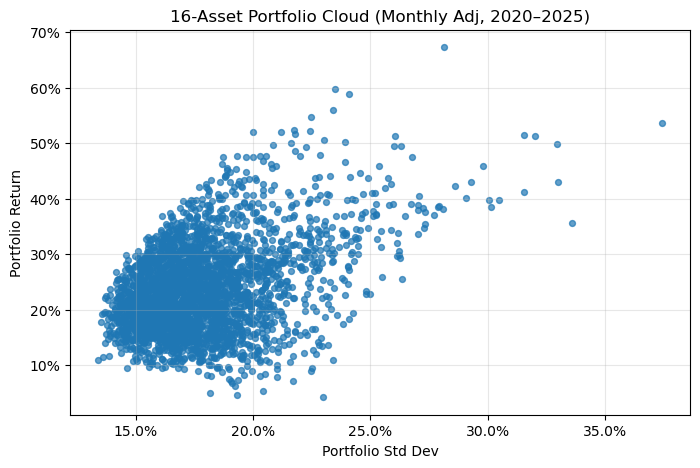

Plot shown.


In [41]:
#simple plotting to check if we are on the right track

from matplotlib.ticker import PercentFormatter #import the percentformatter from the plot package

START = str(px.index.min().date())
END = str(px.index.max().date())

plt.figure(figsize=(8,5))
plt.scatter(port_stds, port_rets, s=18, alpha=0.7)
plt.title(f"{n_assets}-Asset Portfolio Cloud (Monthly Adj, {START[:4]}–{END[:4]})")
plt.xlabel("Portfolio Std Dev")
plt.ylabel("Portfolio Return")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True, alpha=0.3)
plt.show()

print("Plot shown.")

In [42]:
#Extremes: Max-Sharpe and Min-Variance (completely clean print)
rf = 0.04  #4% risk-free rate, 4% is reasonable for today's times

# Why Sharpe? -> Sharpe ratio measures how much excess return (above the risk-free rate) investor earns per unit of risk taken
# -> tells us how efficiently a portfolio converts risk into return
#The higher the Sharpe ratio, the better the risk-adjusted performance

sharpe = (port_rets - rf) / port_stds #normal sharpe formula
ix_s   = int(np.argmax(sharpe))      # max Sharpe, find portfolio with highest sharpe ratio
ix_m   = int(np.argmin(port_stds))   # min variance, find the minimum-variance portfolio

def clean_weights(w):
    """Return a dict with plain floats rounded to 3 decimals."""
    return {str(col): round(float(w[i]), 3) for i, col in enumerate(rets.columns)} #cleaning up for better visualization (not needed)

print(f"\nMax-Sharpe portfolio (rf={rf:.2%})")
print(f"  σ={float(port_stds[ix_s]):.2%}  μ={float(port_rets[ix_s]):.2%}  Sharpe={float(sharpe[ix_s]):.3f}")
print("  weights:", clean_weights(weights[ix_s]))

print("\nMin-Variance portfolio")
print(f"  σ={float(port_stds[ix_m]):.2%}  μ={float(port_rets[ix_m]):.2%}")
print("  weights:", clean_weights(weights[ix_m]))


Max-Sharpe portfolio (rf=4.00%)
  σ=20.01%  μ=52.02%  Sharpe=2.400
  weights: {'ADBE': 0.001, 'ALB': 0.012, 'BRK-B': 0.022, 'GOOGL': 0.043, 'MSFT': 0.06, 'ONOF': 0.191, 'PLTR': 0.083, 'PYPL': 0.013, 'QTUM': 0.048, 'RNMBY': 0.303, 'RSP': 0.007, 'TMUS': 0.015, 'VOO': 0.079, 'VXUS': 0.024, 'VZ': 0.041, 'XLE': 0.058}

Min-Variance portfolio
  σ=13.41%  μ=10.97%
  weights: {'ADBE': 0.005, 'ALB': 0.041, 'BRK-B': 0.047, 'GOOGL': 0.073, 'MSFT': 0.038, 'ONOF': 0.16, 'PLTR': 0.008, 'PYPL': 0.017, 'QTUM': 0.017, 'RNMBY': 0.004, 'RSP': 0.084, 'TMUS': 0.027, 'VOO': 0.032, 'VXUS': 0.01, 'VZ': 0.354, 'XLE': 0.084}


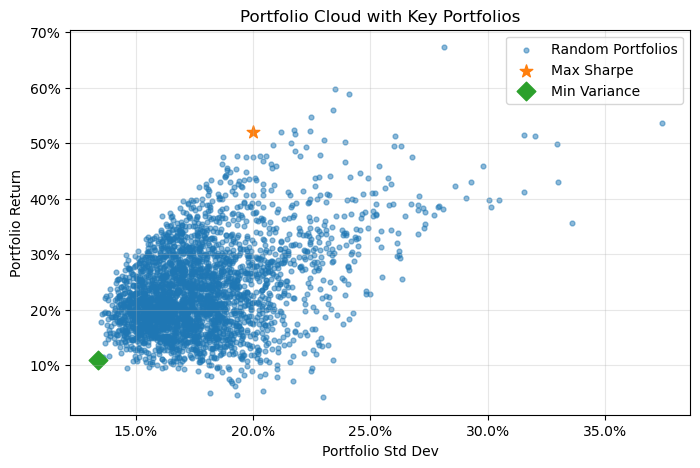

In [46]:
#simple plotting

plt.figure(figsize=(8,5))
plt.scatter(port_stds, port_rets, s=12, alpha=0.5, label="Random Portfolios")
plt.scatter([port_stds[ix_s]], [port_rets[ix_s]], s=90, marker="*", label="Max Sharpe")
plt.scatter([port_stds[ix_m]], [port_rets[ix_m]], s=90, marker="D", label="Min Variance")
plt.title("Portfolio Cloud with Key Portfolios")
plt.xlabel("Portfolio Std Dev"); plt.ylabel("Portfolio Return")
plt.gca().xaxis.set_major_formatter(PercentFormatter(1.0))
plt.gca().yaxis.set_major_formatter(PercentFormatter(1.0))
plt.grid(True, alpha=0.3); plt.legend()
plt.show()